### **Implementing the Transformer Encoder from Scratch**

In [5]:
from tensorflow import math
from keras.backend import softmax
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer,Dense,ReLU,\
    Dropout,LayerNormalization
from pos_encoding import PositionEmbeddingFixedWeights
from multihead import MultiHeadAttention

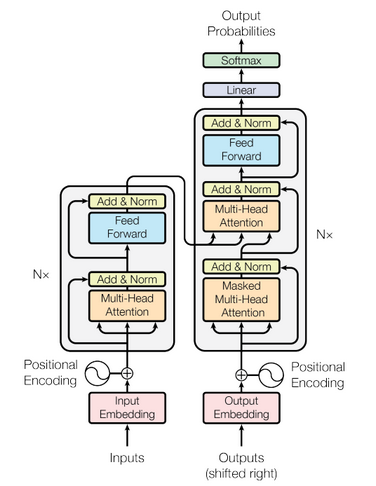

In [6]:
img =Image.open("img/transformer1.PNG") # because it is a PNG file
img = img.convert('RGB')
img

### **Encoder**

In [7]:
# Add & Normalise layer
class AddNormalisation(Layer):
    def __init__(self,**kwargs):
        super(AddNormalisation,self).__init__(**kwargs)
        # layer normalisation
        self.layer_norm = LayerNormalization() 
    
    def call(self,x,sublayer_x):
        # The sublayer input and output 
        # need to be of the same shape to be summed
        add = x + sublayer_x

        # Normalisation
        return self.layer_norm(add)

In [8]:
# Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self,d_ff,d_model,**kwargs):
        super(FeedForward,self).__init__(**kwargs)
        self.fc1  = Dense(d_ff)
        self.fc2  = Dense(d_model)
        self.activation = ReLU()

    def call(self,x):
        x_fc1 = self.fc1(x)
        activate = self.activation(x_fc1)
        x_fc2 = self.fc2(activate)

        return x_fc2

In [9]:
# Encoding Layer 
class EncodingLayer(Layer):
    def __init__(self,h,d_k,d_v,d_model,d_ff,rate,**kwargs) -> None:
        super(EncodingLayer,self).__init__(**kwargs)
        # Define the layers
        self.multihead_attention = MultiHeadAttention(h,d_k,d_v,d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalisation()
        self.ff = FeedForward(d_ff,d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalisation()

    def call(self,x,padding_mask,training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x,x,x,padding_mask)
        # Expected output shape  = batch_size, seqence_length, d_model

        # Dropout layer
        multihead_output = self.dropout1(multihead_output,training=training)

        # Add & Norm layer
        addnorm_output = self.add_norm1(x,multihead_output)
        # Expected output shape  = batch_size, seqence_length, d_model

        # Feed Forward layer
        ff_output = self.ff(addnorm_output)
        # Expected output shape  = batch_size, seqence_length, d_model

        # Dropout layer
        ff_output = self.dropout2(ff_output)

        # Add & Norm layer
        addnorm_output2 = self.add_norm1(addnorm_output,ff_output)

        return addnorm_output2

In [10]:
# Implementing the encoder
class Encoder(Layer):
    def __init__(self,vocab_size,sequence_length,
                    h,d_k,
                    d_v,d_model,
                    d_ff,n,rate,
                    **kwargs):
        super(Encoder,self).__init__(**kwargs)

        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length,
                                vocab_size,d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [
            EncodingLayer(h,d_k,d_v,d_model,d_ff,rate,) for _ in range(n)
        ]

    def call(self,input_sentence,padding_mask,training):
        # Generate positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Dropout layer
        x = self.dropout(pos_encoding_output)
        
        # Pass on the positional encoded values to each encoder layer
        for i,layer in enumerate(self.encoder_layer):
            x = layer(x,padding_mask,training)

        return x

In [11]:
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Rate of dropout



vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
 
input_seq = np.random.random((batch_size, input_seq_length))


encoder = Encoder(vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print("Encoder output:")
print(encoder(input_seq, None, True)) # shape=(64, 5, 512)

Encoder output:
tf.Tensor(
[[[ 2.40687400e-01  1.79346964e-01  1.77274704e+00 ...  1.05049658e+00
   -5.82497977e-02 -3.74988675e-01]
  [-9.82318878e-01 -6.55749738e-01  2.24141002e+00 ...  2.04776108e-01
   -9.09916341e-01  1.95593268e-01]
  [ 3.13995302e-01  1.72422037e-01  2.31693387e+00 ...  1.80960119e-01
   -4.79800522e-01  1.55982628e-01]
  [ 7.93671429e-01 -5.19160092e-01  2.12472367e+00 ...  2.41873354e-01
   -6.60676777e-01 -9.15975869e-01]
  [ 4.24110703e-02 -4.61957633e-01  7.68685281e-01 ...  5.94100833e-01
    2.25821450e-01  2.38681436e-01]]

 [[-1.53624490e-01 -3.45948815e-01  1.70551634e+00 ... -3.66000801e-01
   -5.11073396e-02  5.09783983e-01]
  [-7.63421774e-01 -7.23816603e-02  1.44878590e+00 ... -5.23024023e-01
   -8.37010145e-01 -1.14249611e+00]
  [ 4.26938087e-01 -8.53366196e-01  1.84434342e+00 ... -4.18678164e-01
   -3.27159017e-01  3.38850200e-01]
  [-1.91064447e-01 -1.02119994e+00  1.57295930e+00 ...  2.89824426e-01
    4.04591598e-02 -8.13727438e-01]
  [ 3.97